In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_age')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','X003R']]
income.head()

,D_INTERVIEW,X003R
0,196070011,5
1,196070036,5
2,196070039,3
3,196070040,5
4,196070053,4


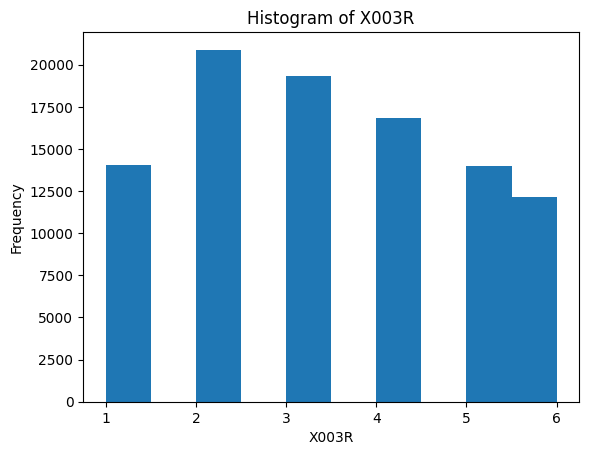

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['X003R'])
plt.xlabel('X003R')
plt.ylabel('Frequency')
plt.title('Histogram of X003R')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,X003R,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,5,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,5,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,5,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,4,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['X003R'] > 3]
df_merged.head()

,D_INTERVIEW,X003R,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,5,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,5,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
3,196070040,5,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,4,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3
6,196070067,5,4.666667,CYP,6.0,1,4.0,-1.068037,-0.623011,0.764001,...,-1.092566,0.739553,0.976462,0.685612,0.323946,0.884878,1,1,9,3


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_elderly_best_params.json")

[I 2025-06-15 19:03:23,329] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.407775
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.399988
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.400307
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.402984
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398106


[I 2025-06-15 19:12:18,730] Trial 0 finished with value: 0.4018320787555606 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.4018320787555606.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.44045
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.430845
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.43211
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.435208
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.428488


[I 2025-06-15 19:22:50,850] Trial 1 finished with value: 0.43341998122431435 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.4018320787555606.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.953263
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.946558
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.947753
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.949788
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.947962


[I 2025-06-15 19:34:33,229] Trial 2 finished with value: 0.9490648196836308 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.4018320787555606.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49938
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49169
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49342
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49465
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49821


[I 2025-06-15 19:41:01,099] Trial 3 finished with value: 1.4954698392615566 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.4018320787555606.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.405431
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398542
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398524
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.400513
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.397179


[I 2025-06-15 19:54:30,763] Trial 4 finished with value: 0.40003778969686155 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.40003778969686155.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.980329
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.977413
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.97229
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.975582
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.979679


[I 2025-06-15 20:06:15,385] Trial 5 finished with value: 0.9770587064745669 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.40003778969686155.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.411692
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.404342
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.4062
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.40877
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.400816


[I 2025-06-15 20:12:28,077] Trial 6 finished with value: 0.4063639589299868 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.40003778969686155.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.401824
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.395255
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.395435
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398595
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.395273


[I 2025-06-15 20:28:21,788] Trial 7 finished with value: 0.3972764430617073 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.40874
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399347
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.402668
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.404707
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399824


[I 2025-06-15 20:39:08,146] Trial 8 finished with value: 0.4030573443015119 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.28334
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27746
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27782
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27886
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.28065


[I 2025-06-15 20:47:13,396] Trial 9 finished with value: 1.2796243520544022 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 20:47:30,270] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.406034
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398577
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.40033
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.402613
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399728


[I 2025-06-15 20:59:52,420] Trial 11 finished with value: 0.4014562950973354 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:00:16,104] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:01:22,291] Trial 13 pruned. Trial was pruned at iteration 221.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:01:44,094] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:02:10,048] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.407149
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.400161
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.399996
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.401674
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398566


[I 2025-06-15 21:16:20,955] Trial 16 finished with value: 0.4015090806577756 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:16:34,543] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:17:02,692] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:17:25,237] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 21:17:42,947] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.404739
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.397865
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.396336
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.400946
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.398528


[I 2025-06-15 21:31:15,186] Trial 21 finished with value: 0.3996826108235339 and parameters: {'num_leaves': 77, 'learning_rate': 0.039278950418040956, 'max_depth': 9, 'reg_alpha': 0.14154405943530612, 'reg_lambda': 0.2835833892843662, 'feature_fraction': 0.6345014591864532, 'bagging_fraction': 0.7960179725530865, 'bagging_freq': 7, 'min_data_in_leaf': 281}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.406135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid's rmse: 0.398823
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.398017
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.403292
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.39823


[I 2025-06-15 21:44:47,039] Trial 22 finished with value: 0.40089928162292165 and parameters: {'num_leaves': 81, 'learning_rate': 0.04676998078903025, 'max_depth': 12, 'reg_alpha': 0.007933178836437677, 'reg_lambda': 0.217074541962206, 'feature_fraction': 0.7252140483203631, 'bagging_fraction': 0.759508442563944, 'bagging_freq': 7, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.404138
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.39693
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.39794
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.40112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.396654


[I 2025-06-15 21:58:06,467] Trial 23 finished with value: 0.39935636322856716 and parameters: {'num_leaves': 91, 'learning_rate': 0.04103250762123793, 'max_depth': 9, 'reg_alpha': 0.029136420576304948, 'reg_lambda': 1.6031421014353249, 'feature_fraction': 0.6714426247822578, 'bagging_fraction': 0.7539027784631227, 'bagging_freq': 6, 'min_data_in_leaf': 314}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.401844
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.397146
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.395463
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.401556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid's rmse: 0.39408


[I 2025-06-15 22:09:05,667] Trial 24 finished with value: 0.39801791629922983 and parameters: {'num_leaves': 108, 'learning_rate': 0.06336694819664737, 'max_depth': 9, 'reg_alpha': 3.867755526076228, 'reg_lambda': 0.9348406243708022, 'feature_fraction': 0.51214378803766, 'bagging_fraction': 0.7500665176846019, 'bagging_freq': 6, 'min_data_in_leaf': 316}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.404781
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.398477
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.396664
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.401459
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.396296


[I 2025-06-15 22:18:17,830] Trial 25 finished with value: 0.39953536193931083 and parameters: {'num_leaves': 112, 'learning_rate': 0.0689947499119543, 'max_depth': 7, 'reg_alpha': 3.102862430394538, 'reg_lambda': 1.1012547397820738, 'feature_fraction': 0.5237386913304256, 'bagging_fraction': 0.6473414417901787, 'bagging_freq': 6, 'min_data_in_leaf': 397}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 22:18:40,458] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid's rmse: 0.4062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid's rmse: 0.401926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid's rmse: 0.402173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid's rmse: 0.407886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid's rmse: 0.399442


[I 2025-06-15 22:26:49,196] Trial 27 finished with value: 0.40352558678867523 and parameters: {'num_leaves': 101, 'learning_rate': 0.09727263951888995, 'max_depth': 10, 'reg_alpha': 0.4489930658218551, 'reg_lambda': 0.6979216351910185, 'feature_fraction': 0.5215785828356199, 'bagging_fraction': 0.6742675373732645, 'bagging_freq': 4, 'min_data_in_leaf': 305}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 22:27:07,569] Trial 28 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.402255
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.3985
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.396065
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.401874
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394047


[I 2025-06-15 22:40:20,155] Trial 29 finished with value: 0.39854788029309657 and parameters: {'num_leaves': 89, 'learning_rate': 0.05773555104787926, 'max_depth': 9, 'reg_alpha': 0.016748804018540543, 'reg_lambda': 0.006769296221162642, 'feature_fraction': 0.5666674144463874, 'bagging_fraction': 0.83145617369267, 'bagging_freq': 3, 'min_data_in_leaf': 492}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.404668
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.397441
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.395857
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.400137
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394292


[I 2025-06-15 22:54:21,853] Trial 30 finished with value: 0.39847877695206535 and parameters: {'num_leaves': 117, 'learning_rate': 0.05416760778554196, 'max_depth': 11, 'reg_alpha': 0.02068436492353106, 'reg_lambda': 0.005613260916303199, 'feature_fraction': 0.5276954989256775, 'bagging_fraction': 0.8358762287099257, 'bagging_freq': 3, 'min_data_in_leaf': 484}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.402067
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.398395
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.397099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[474]	valid's rmse: 0.399465
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.394864


[I 2025-06-15 23:08:20,117] Trial 31 finished with value: 0.3983780228427015 and parameters: {'num_leaves': 118, 'learning_rate': 0.06560133321203092, 'max_depth': 11, 'reg_alpha': 0.020562720191030094, 'reg_lambda': 0.005834874830062052, 'feature_fraction': 0.5562561434765995, 'bagging_fraction': 0.834583676975722, 'bagging_freq': 3, 'min_data_in_leaf': 499}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[463]	valid's rmse: 0.404587
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.397496
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.397411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid's rmse: 0.402309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid's rmse: 0.396186


[I 2025-06-15 23:21:46,397] Trial 32 finished with value: 0.399597865511495 and parameters: {'num_leaves': 121, 'learning_rate': 0.06850364285859653, 'max_depth': 11, 'reg_alpha': 0.027575211704022252, 'reg_lambda': 0.0031308220843275798, 'feature_fraction': 0.528833905306858, 'bagging_fraction': 0.779845242466242, 'bagging_freq': 2, 'min_data_in_leaf': 458}. Best is trial 7 with value: 0.3972764430617073.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.401824
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[469]	valid's rmse: 0.395542
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.393127
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.399243
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.391858


[I 2025-06-15 23:35:14,348] Trial 33 finished with value: 0.3963188326780376 and parameters: {'num_leaves': 141, 'learning_rate': 0.05794458677710714, 'max_depth': 11, 'reg_alpha': 0.06397962199162827, 'reg_lambda': 0.0007684688098138078, 'feature_fraction': 0.47201860155962316, 'bagging_fraction': 0.9099609216639752, 'bagging_freq': 4, 'min_data_in_leaf': 473}. Best is trial 33 with value: 0.3963188326780376.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	valid's rmse: 0.404622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid's rmse: 0.397651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid's rmse: 0.398883
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	valid's rmse: 0.393591


[I 2025-06-15 23:46:08,661] Trial 34 finished with value: 0.3978858804949594 and parameters: {'num_leaves': 137, 'learning_rate': 0.08268064501525922, 'max_depth': 11, 'reg_alpha': 8.533857920904037, 'reg_lambda': 0.0005202532358780492, 'feature_fraction': 0.4468768862941919, 'bagging_fraction': 0.9125287951573587, 'bagging_freq': 4, 'min_data_in_leaf': 438}. Best is trial 33 with value: 0.3963188326780376.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[474]	valid's rmse: 0.401725
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.395895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid's rmse: 0.393629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid's rmse: 0.398369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid's rmse: 0.393329


[I 2025-06-15 23:58:45,458] Trial 35 finished with value: 0.3965894135795923 and parameters: {'num_leaves': 141, 'learning_rate': 0.08623028020858228, 'max_depth': 12, 'reg_alpha': 7.981079905206858, 'reg_lambda': 0.0005736429016281454, 'feature_fraction': 0.42695666398052345, 'bagging_fraction': 0.9889241351856959, 'bagging_freq': 4, 'min_data_in_leaf': 438}. Best is trial 33 with value: 0.3963188326780376.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 23:59:08,727] Trial 36 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[301]	valid's rmse: 0.402179
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid's rmse: 0.396498
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[446]	valid's rmse: 0.395178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	valid's rmse: 0.397853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid's rmse: 0.393437


[I 2025-06-16 00:10:39,841] Trial 37 finished with value: 0.3970290558621971 and parameters: {'num_leaves': 142, 'learning_rate': 0.08484832872878982, 'max_depth': 12, 'reg_alpha': 4.876496868606219, 'reg_lambda': 0.0007263574958731232, 'feature_fraction': 0.4564309786617238, 'bagging_fraction': 0.9213790878953952, 'bagging_freq': 4, 'min_data_in_leaf': 427}. Best is trial 33 with value: 0.3963188326780376.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 00:13:04,866] Trial 38 pruned. Trial was pruned at iteration 477.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 00:13:31,821] Trial 39 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.400018
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.396078
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.395006
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.397562
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.391093


[I 2025-06-16 00:27:00,784] Trial 40 finished with value: 0.3959514638965552 and parameters: {'num_leaves': 142, 'learning_rate': 0.05084560839006026, 'max_depth': 10, 'reg_alpha': 0.938013316481755, 'reg_lambda': 0.0024503331403421718, 'feature_fraction': 0.4814777119692351, 'bagging_fraction': 0.9084535906700919, 'bagging_freq': 5, 'min_data_in_leaf': 420}. Best is trial 40 with value: 0.3959514638965552.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.400454
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.394532
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.393933
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.397488
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.389875


[I 2025-06-16 00:40:20,128] Trial 41 finished with value: 0.3952563092794428 and parameters: {'num_leaves': 142, 'learning_rate': 0.046730086728387646, 'max_depth': 10, 'reg_alpha': 1.3788247989221158, 'reg_lambda': 0.002038863722508489, 'feature_fraction': 0.4845218040186453, 'bagging_fraction': 0.8947911464226286, 'bagging_freq': 5, 'min_data_in_leaf': 417}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.401343
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[478]	valid's rmse: 0.396171
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.392845
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.39683
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.391279


[I 2025-06-16 00:53:36,332] Trial 42 finished with value: 0.3956936881652682 and parameters: {'num_leaves': 141, 'learning_rate': 0.05253712398302984, 'max_depth': 10, 'reg_alpha': 1.0562222225623477, 'reg_lambda': 0.0020566591035993936, 'feature_fraction': 0.4897651287389364, 'bagging_fraction': 0.9029448076643083, 'bagging_freq': 4, 'min_data_in_leaf': 430}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.402861
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.395329
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.392323
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.397361
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[467]	valid's rmse: 0.392697


[I 2025-06-16 01:06:41,666] Trial 43 finished with value: 0.3961143729089024 and parameters: {'num_leaves': 127, 'learning_rate': 0.05189076752116647, 'max_depth': 10, 'reg_alpha': 1.1913485625541382, 'reg_lambda': 0.0024642627747471254, 'feature_fraction': 0.49254883904642205, 'bagging_fraction': 0.8925012628080955, 'bagging_freq': 5, 'min_data_in_leaf': 470}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 01:07:07,235] Trial 44 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399707
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.39493
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394341
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399083
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[463]	valid's rmse: 0.391101


[I 2025-06-16 01:20:48,011] Trial 45 finished with value: 0.3958327175230952 and parameters: {'num_leaves': 134, 'learning_rate': 0.05006452107580624, 'max_depth': 10, 'reg_alpha': 1.0201579158514904, 'reg_lambda': 0.01552743391698029, 'feature_fraction': 0.4770078023008106, 'bagging_fraction': 0.9623260911123275, 'bagging_freq': 5, 'min_data_in_leaf': 413}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.400685
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.395199
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.391748
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.397538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	valid's rmse: 0.3913


[I 2025-06-16 01:34:41,335] Trial 46 finished with value: 0.395293959977011 and parameters: {'num_leaves': 134, 'learning_rate': 0.049803178384711995, 'max_depth': 10, 'reg_alpha': 1.134088326022531, 'reg_lambda': 0.016885250130710027, 'feature_fraction': 0.4897956196291442, 'bagging_fraction': 0.9693987970832496, 'bagging_freq': 5, 'min_data_in_leaf': 368}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 01:35:06,933] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 01:35:37,583] Trial 48 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.400067
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.396898
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.393817
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.399142
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.39433


[I 2025-06-16 01:50:21,145] Trial 49 finished with value: 0.3968510081214417 and parameters: {'num_leaves': 132, 'learning_rate': 0.04567637356594513, 'max_depth': 10, 'reg_alpha': 1.8787685960118359, 'reg_lambda': 0.034643465684328814, 'feature_fraction': 0.5434999847945761, 'bagging_fraction': 0.9594210740696271, 'bagging_freq': 5, 'min_data_in_leaf': 367}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 01:50:40,815] Trial 50 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.399862
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.395436
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.393322
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.398418
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.392577


[I 2025-06-16 02:04:20,099] Trial 51 finished with value: 0.3959228940934107 and parameters: {'num_leaves': 134, 'learning_rate': 0.050311441923726614, 'max_depth': 10, 'reg_alpha': 1.0880634079922353, 'reg_lambda': 0.003664481011812929, 'feature_fraction': 0.4960007498516489, 'bagging_fraction': 0.9049579692751124, 'bagging_freq': 5, 'min_data_in_leaf': 412}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:04:45,050] Trial 52 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.401031
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[477]	valid's rmse: 0.394391
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.393352
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.39959
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.392332


[I 2025-06-16 02:18:00,345] Trial 53 finished with value: 0.3961394637544526 and parameters: {'num_leaves': 132, 'learning_rate': 0.05519576060768011, 'max_depth': 9, 'reg_alpha': 0.26236485768134626, 'reg_lambda': 0.001550209223008919, 'feature_fraction': 0.5049279346201913, 'bagging_fraction': 0.9985950422792227, 'bagging_freq': 5, 'min_data_in_leaf': 451}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:18:25,469] Trial 54 pruned. Trial was pruned at iteration 53.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:18:52,497] Trial 55 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:19:18,205] Trial 56 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:19:46,508] Trial 57 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:20:04,472] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:20:25,344] Trial 59 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:20:48,262] Trial 60 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:22:48,603] Trial 61 pruned. Trial was pruned at iteration 399.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:23:12,659] Trial 62 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:23:39,213] Trial 63 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.401733
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.394125
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394855
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.398089
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.391169


[I 2025-06-16 02:36:40,395] Trial 64 finished with value: 0.3959942315212851 and parameters: {'num_leaves': 145, 'learning_rate': 0.05701665618247306, 'max_depth': 9, 'reg_alpha': 0.40082019050627293, 'reg_lambda': 0.003978855515494589, 'feature_fraction': 0.5187571109727325, 'bagging_fraction': 0.9551322853818054, 'bagging_freq': 5, 'min_data_in_leaf': 416}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.401067
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.395205
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.394315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid's rmse: 0.40091
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[472]	valid's rmse: 0.390927


[I 2025-06-16 02:48:31,225] Trial 65 finished with value: 0.39648479955259786 and parameters: {'num_leaves': 145, 'learning_rate': 0.06097779422848002, 'max_depth': 9, 'reg_alpha': 0.33486918795475684, 'reg_lambda': 0.004218305172377537, 'feature_fraction': 0.42111346322448023, 'bagging_fraction': 0.977638259671344, 'bagging_freq': 4, 'min_data_in_leaf': 396}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:48:53,745] Trial 66 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:49:13,589] Trial 67 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:49:38,568] Trial 68 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:50:01,909] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 02:50:50,789] Trial 70 pruned. Trial was pruned at iteration 118.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.40184
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[462]	valid's rmse: 0.396208
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.393506
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.397624
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid's rmse: 0.391271


[I 2025-06-16 03:03:51,142] Trial 71 finished with value: 0.3960897267599934 and parameters: {'num_leaves': 129, 'learning_rate': 0.054231702846154826, 'max_depth': 10, 'reg_alpha': 1.6974552549393207, 'reg_lambda': 0.0027293015041079944, 'feature_fraction': 0.48573190683865336, 'bagging_fraction': 0.9046423241647629, 'bagging_freq': 5, 'min_data_in_leaf': 437}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.401328
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.396728
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394818
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.397892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid's rmse: 0.391543


[I 2025-06-16 03:16:12,647] Trial 72 finished with value: 0.39646155493317714 and parameters: {'num_leaves': 132, 'learning_rate': 0.06117768391996635, 'max_depth': 10, 'reg_alpha': 1.4636196221207667, 'reg_lambda': 0.002761491258617139, 'feature_fraction': 0.47460336599755404, 'bagging_fraction': 0.9098581769549933, 'bagging_freq': 5, 'min_data_in_leaf': 440}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:16:35,167] Trial 73 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:16:48,830] Trial 74 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:17:06,440] Trial 75 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:17:31,443] Trial 76 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:17:56,773] Trial 77 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:18:23,069] Trial 78 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:19:22,008] Trial 79 pruned. Trial was pruned at iteration 135.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:19:51,478] Trial 80 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.400819
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.395915
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.392873
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.398203
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.392305


[I 2025-06-16 03:32:38,393] Trial 81 finished with value: 0.3960228006168405 and parameters: {'num_leaves': 125, 'learning_rate': 0.05220613618187198, 'max_depth': 10, 'reg_alpha': 0.9553126563708431, 'reg_lambda': 0.0021240818052051646, 'feature_fraction': 0.4849165046157521, 'bagging_fraction': 0.8905174025845457, 'bagging_freq': 5, 'min_data_in_leaf': 469}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:33:29,944] Trial 82 pruned. Trial was pruned at iteration 134.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:34:17,643] Trial 83 pruned. Trial was pruned at iteration 121.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:35:58,271] Trial 84 pruned. Trial was pruned at iteration 247.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:36:18,496] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:37:35,893] Trial 86 pruned. Trial was pruned at iteration 137.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:38:21,068] Trial 87 pruned. Trial was pruned at iteration 133.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:38:46,434] Trial 88 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:39:12,618] Trial 89 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:40:14,316] Trial 90 pruned. Trial was pruned at iteration 158.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:40:40,702] Trial 91 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 03:41:06,384] Trial 92 pruned. Trial was pruned at iteration 52.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.401962
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.39426
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.394962
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.397786
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[466]	valid's rmse: 0.391465


[I 2025-06-16 03:54:19,749] Trial 93 finished with value: 0.3960868060952905 and parameters: {'num_leaves': 143, 'learning_rate': 0.05733833558530033, 'max_depth': 10, 'reg_alpha': 0.733357203288103, 'reg_lambda': 0.004239895403771972, 'feature_fraction': 0.5189832170276095, 'bagging_fraction': 0.9028870171031651, 'bagging_freq': 5, 'min_data_in_leaf': 421}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[465]	valid's rmse: 0.402061
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid's rmse: 0.396829
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.392867
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.400338
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[476]	valid's rmse: 0.392353


[I 2025-06-16 04:06:14,933] Trial 94 finished with value: 0.3968896730546795 and parameters: {'num_leaves': 143, 'learning_rate': 0.06458034641505493, 'max_depth': 9, 'reg_alpha': 0.7642648696069995, 'reg_lambda': 0.0039564107035501995, 'feature_fraction': 0.5303392415628921, 'bagging_fraction': 0.8689357736954613, 'bagging_freq': 5, 'min_data_in_leaf': 422}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 04:06:40,903] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.400687
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.39618
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[389]	valid's rmse: 0.392395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[402]	valid's rmse: 0.397213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid's rmse: 0.393001


[I 2025-06-16 04:18:36,884] Trial 96 finished with value: 0.3958952538713998 and parameters: {'num_leaves': 141, 'learning_rate': 0.05482775896767667, 'max_depth': 11, 'reg_alpha': 0.10821705077883538, 'reg_lambda': 0.002973994450070225, 'feature_fraction': 0.41818647890798766, 'bagging_fraction': 0.9061695438800513, 'bagging_freq': 6, 'min_data_in_leaf': 188}. Best is trial 41 with value: 0.3952563092794428.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 04:20:46,919] Trial 97 pruned. Trial was pruned at iteration 393.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 04:21:08,608] Trial 98 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-16 04:21:59,471] Trial 99 pruned. Trial was pruned at iteration 228.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_elderly_best_params.json",
    save_model_path='exp_elderly_model.txt',
    save_log_filename="exp_elderly_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.553512	valid's l2: 0.306376
[100]	valid's rmse: 0.41503	valid's l2: 0.17225
[150]	valid's rmse: 0.402067	valid's l2: 0.161658
[200]	valid's rmse: 0.398831	valid's l2: 0.159066
[250]	valid's rmse: 0.397121	valid's l2: 0.157705
[300]	valid's rmse: 0.396361	valid's l2: 0.157102
[350]	valid's rmse: 0.39565	valid's l2: 0.156539
[400]	valid's rmse: 0.39535	valid's l2: 0.156302
[450]	valid's rmse: 0.395005	valid's l2: 0.156029
[500]	valid's rmse: 0.394899	valid's l2: 0.155946
[550]	valid's rmse: 0.394797	valid's l2: 0.155864
[600]	valid's rmse: 0.394646	valid's l2: 0.155745
[650]	valid's rmse: 0.394522	valid's l2: 0.155648
[700]	valid's rmse: 0.394484	valid's l2: 0.155617
Early stopping, best iteration is:
[690]	valid's rmse: 0.394373	valid's l2: 0.15553


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

The standard deviation of y is: 1.8397234240667621


In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_elderly_results",
    max_display=30)